### Import Packages

In [545]:
%matplotlib inline
import csv
import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import patsy
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV


import requests
import sys
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import time
import chromedriver_binary

### Web Scrapping

In [172]:
# generate a list of urls
diamond_shape = ['Round', 'Princess', 'Cushion', 'Pear', 'Marquise', 'Emerald', 'Radiant', 'Oval', 'Heart', 'Asscher', 'Trillion', 'Baguette']
url = []
url_str = 'https://www.diamondse.info/diamondsearch.asp?shape='

for word in diamond_shape:
    url_addr = url_str + word
    url.append(url_addr)

print(url)

['https://www.diamondse.info/diamondsearch.asp?shape=Round', 'https://www.diamondse.info/diamondsearch.asp?shape=Princess', 'https://www.diamondse.info/diamondsearch.asp?shape=Cushion', 'https://www.diamondse.info/diamondsearch.asp?shape=Pear', 'https://www.diamondse.info/diamondsearch.asp?shape=Marquise', 'https://www.diamondse.info/diamondsearch.asp?shape=Emerald', 'https://www.diamondse.info/diamondsearch.asp?shape=Radiant', 'https://www.diamondse.info/diamondsearch.asp?shape=Oval', 'https://www.diamondse.info/diamondsearch.asp?shape=Heart', 'https://www.diamondse.info/diamondsearch.asp?shape=Asscher', 'https://www.diamondse.info/diamondsearch.asp?shape=Trillion', 'https://www.diamondse.info/diamondsearch.asp?shape=Baguette']


In [173]:
# manually get url by each (ideally should automate this process...)
url = 'https://www.diamondse.info/diamondsearch.asp?shape=Round'

In [174]:
# set up chrome webdriver
driver = webdriver.Chrome()
driver.get(url)
time.sleep(0.5)

driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(0.5)

In [175]:
# find the table containing products information
product_table = driver.find_element_by_xpath("//*[@id='products']");
content = product_table.text

In [ ]:
# web scraping data table from all pages for each diamond shape
next_button = driver.find_element_by_xpath('//*[@class = "paginate_enabled_next"]')
results = [] 
found_next_button = True
while found_next_button:
    product_table = driver.find_element_by_xpath("//*[@id='products']")
    content = product_table.text
    content_list = content.split('\n')[1:]
    
    for row in content_list:
        results.append(row.split()) #return a list of lists, each list as splitted string values
        #write to csv here
    try:
        next_button.click()
        time.sleep(0.5)
    except:
        found_next_button = False     

In [ ]:
# validate if the data scrapped equals to the actual amount from the website
len(results)

In [ ]:
# create data frame for each diamond shape category
df_round = pd.DataFrame.from_records(results)
df_princess = pd.DataFrame.from_records(results)
df_cushion = pd.DataFrame.from_records(results)
df_pear = pd.DataFrame.from_records(results)
df_marquise = pd.DataFrame.from_records(results)
df_emerald = pd.DataFrame.from_records(results)
df_Radiant = pd.DataFrame.from_records(results)
df_oval = pd.DataFrame.from_records(results)
df_heart = pd.DataFrame.from_records(results)
df_asscher = pd.DataFrame.from_records(results)

In [ ]:
# cancates all fancy shape diamonds into a single data frame 
# I was in the tidious process of scraping data...this is just in case of losing data
fancy_shape = [df_Radiant,df_oval,df_heart,df_asscher,df_emerald,df_marquise,df_pear,df_cushion,df_princess]
fancy_shape = pd.concat(fancy_shape)

In [ ]:
# concate the fancy shape diamonds data frame with round shape diamond data frame
diamonds_total = [fancy_shape, df_round]
diamonds_total = pd.concat(diamonds_total)

In [ ]:
# export the data into csv file for future usage!
# I'm officially done with scrapping 361973 rows of data!
fancy_shape.to_csv("fancy_shape.csv", index = None, header=False)
df_round.to_csv("round_shape.csv", index = None, header=False)
diamonds_total.to_csv("diamonds_total.csv",index = None, header=False)

### Data Cleaning and EDA

In [603]:
# display only 15 rows of results in each cell
pd.options.display.max_rows = 15

In [604]:
diamonds_total = pd.read_csv("diamonds_total.csv", header = None)

In [605]:
diamonds_total.to_pickle('diamonds_total.pkl')

In [606]:
pd.read_pickle('diamonds_total.pkl', compression='infer')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Radiant,0.22,Ideal,E,SI1,68.0,64.5,GIA,4.25,x,3.19,x,2.06,$176
1,Radiant,0.24,Ideal,H,VS1,61.0,65.6,GIA,4.04,x,3.34,x,2.19,$179
2,Radiant,0.30,Good,G,I1,69.8,82.0,GIA,3.94,x,3.68,x,2.57,$181
3,Radiant,0.34,Ideal,H,I1,58.0,68.5,GIA,4.14,x,3.79,x,2.60,$223
4,Radiant,0.46,Ideal,K,SI2,87.0,72.2,GIA,4.62,x,4.19,x,3.03,$280
5,Radiant,0.31,V.Good,E,SI1,68.0,67.5,GIA,4.30,x,3.49,x,2.36,$300
6,Radiant,0.47,V.Good,G,I1,83.0,59.2,GIA,5.04,x,4.44,x,2.63,$301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361966,Round,20.01,Ideal,I,VVS2,60.0,59.4,GIA,17.63,x,17.70,x,10.49,"$705,603"
361967,Round,11.50,Ideal,E,VS2,58.0,60.3,GIA,14.59,x,14.61,x,8.81,"$705,917"


In [607]:
diamonds_total.drop([9,11], axis=1, inplace=True)

In [608]:
diamonds_total.head()

,0,1,2,3,4,5,6,7,8,10,12,13
0,Radiant,0.22,Ideal,E,SI1,68.0,64.5,GIA,4.25,3.19,2.06,$176
1,Radiant,0.24,Ideal,H,VS1,61.0,65.6,GIA,4.04,3.34,2.19,$179
2,Radiant,0.30,Good,G,I1,69.8,82.0,GIA,3.94,3.68,2.57,$181
3,Radiant,0.34,Ideal,H,I1,58.0,68.5,GIA,4.14,3.79,2.60,$223
4,Radiant,0.46,Ideal,K,SI2,87.0,72.2,GIA,4.62,4.19,3.03,$280


In [609]:
diamonds_total.rename(columns=
                      {0:"Shape",
                       1:"Carat",
                       2:"Cut",
                       3:"Color",
                       4:"Clarity",
                       5:"Table",
                       6:"DepthPer",
                       7:"Cert",
                       8:"Length",
                       10:"Width",
                       12:"Depth",
                       13:"Price"},
                      inplace= True)

In [610]:
diamonds_total.head()

,Shape,Carat,Cut,Color,Clarity,Table,DepthPer,Cert,Length,Width,Depth,Price
0,Radiant,0.22,Ideal,E,SI1,68.0,64.5,GIA,4.25,3.19,2.06,$176
1,Radiant,0.24,Ideal,H,VS1,61.0,65.6,GIA,4.04,3.34,2.19,$179
2,Radiant,0.30,Good,G,I1,69.8,82.0,GIA,3.94,3.68,2.57,$181
3,Radiant,0.34,Ideal,H,I1,58.0,68.5,GIA,4.14,3.79,2.60,$223
4,Radiant,0.46,Ideal,K,SI2,87.0,72.2,GIA,4.62,4.19,3.03,$280


In [611]:
# detect duplicate rows and remove them, otherwise will have esitimation bias
# all duplicated rows except their first occurence are marked as True
# Rows that were "observed" more than once(like roll a dice twice as 6) should be valuable for the analysis
# but in my case, it's not worthy to keep them since they are just duplicated records with the same predictors and outcome pairs from different databases
# 39191 rows × 12 columns are duplicate rows
diamonds_total[diamonds_total.duplicated(subset = None, keep = 'first')== True].head()

,Shape,Carat,Cut,Color,Clarity,Table,DepthPer,Cert,Length,Width,Depth,Price
40,Radiant,0.38,Good,I,VS1,75.0,62.3,GIA,4.77,3.90,2.43,$398
41,Radiant,0.30,V.Good,F,VVS1,65.0,62.5,GIA,4.92,3.52,2.20,$399
42,Radiant,0.31,V.Good,I,IF,66.0,71.7,GIA,4.29,3.52,2.52,$400
43,Radiant,0.30,V.Good,F,VVS1,65.0,63.7,GIA,4.82,3.49,2.22,$403
44,Radiant,0.40,Good,J,SI1,71.0,75.2,GIA,4.36,3.86,2.90,$405


In [612]:
# drop the duplicated rows (39191 rows)
diamonds_total = diamonds_total.drop_duplicates(subset= None, keep='first')

In [613]:
diamonds_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322782 entries, 0 to 361972
Data columns (total 12 columns):
Shape       322782 non-null object
Carat       322782 non-null float64
Cut         322782 non-null object
Color       322782 non-null object
Clarity     322782 non-null object
Table       322782 non-null float64
DepthPer    322782 non-null float64
Cert        322782 non-null object
Length      322782 non-null float64
Width       322782 non-null float64
Depth       322782 non-null float64
Price       322782 non-null object
dtypes: float64(6), object(6)
memory usage: 32.0+ MB


In [614]:
# convert the "Price" column to numeric data type
# at first I have price as float type but my cross validation cannot run with such large dataset. so I convert price to int
diamonds_total['Price'] = diamonds_total['Price'].replace('[\$,]','',regex = True).astype(int)

In [615]:
diamonds_total.describe()

,Carat,Table,DepthPer,Length,Width,Depth,Price
count,322782.000000,322782.000000,322782.000000,322782.000000,322782.000000,322782.000000,322782.000000
mean,0.802626,59.362155,63.126413,5.702527,5.367057,3.386182,5452.951475
std,0.781062,4.117676,3.597180,1.532216,1.219007,0.810387,20423.380728
min,0.200000,0.600000,0.600000,0.000000,0.000000,0.000000,123.000000
25%,0.380000,57.000000,61.400000,4.600000,4.480000,2.800000,676.000000
50%,0.530000,58.000000,62.400000,5.220000,5.090000,3.190000,1429.000000
75%,1.000000,60.000000,63.800000,6.390000,5.880000,3.810000,3809.000000
max,20.530000,89.000000,89.800000,21.120000,62.600000,72.000000,969321.000000


In [616]:
# from the df.describe() we see that there are 0s in the "Length(mm)","Width(mm)", and "Depth(mm)" columns
# which cannot be true since loose diamonds must have those physical measurements
# so these rows with 0s will be treated as missing values and need to be removed from the dataframe
diamonds_total[['Length','Width','Depth']] = diamonds_total[['Length','Width','Depth']].replace(0, np.nan)

In [617]:
# check out which rows contain null values
diamonds_total.loc[diamonds_total['Length'].isnull()]
diamonds_total.loc[diamonds_total['Width'].isnull()]
diamonds_total.loc[diamonds_total['Depth'].isnull()]

,Shape,Carat,Cut,Color,Clarity,Table,DepthPer,Cert,Length,Width,Depth,Price
95466,Round,0.35,Ideal,K,SI2,59.0,60.8,GIA,NaN,NaN,NaN,276
97104,Round,0.33,Ideal,L,VS1,56.0,62.5,GIA,NaN,NaN,NaN,335
99361,Round,0.23,Ideal,D,VVS2,61.0,60.7,GIA,NaN,NaN,NaN,365
99435,Round,0.21,Ideal,E,VVS1,55.0,62.2,GIA,NaN,NaN,NaN,366
100569,Round,0.42,Ideal,J,I1,57.0,62.0,GIA,NaN,NaN,NaN,377
100670,Round,0.40,V.Good,F,I1,60.0,59.8,GIA,NaN,NaN,NaN,378
104465,Round,0.30,Good,F,VS2,55.0,65.8,GIA,NaN,NaN,NaN,404
...,...,...,...,...,...,...,...,...,...,...,...,...
301545,Round,1.00,Ideal,E,SI2,55.0,62.9,GIA,NaN,NaN,NaN,4399
301731,Round,1.00,V.Good,H,SI2,56.0,62.3,GIA,NaN,NaN,NaN,4417


In [618]:
# drop the observations with null value
# 82 rows have been dropped
diamonds_total.dropna(inplace = True)
diamonds_total.reset_index()
diamonds_total

,Shape,Carat,Cut,Color,Clarity,Table,DepthPer,Cert,Length,Width,Depth,Price
0,Radiant,0.22,Ideal,E,SI1,68.0,64.5,GIA,4.25,3.19,2.06,176
1,Radiant,0.24,Ideal,H,VS1,61.0,65.6,GIA,4.04,3.34,2.19,179
2,Radiant,0.30,Good,G,I1,69.8,82.0,GIA,3.94,3.68,2.57,181
3,Radiant,0.34,Ideal,H,I1,58.0,68.5,GIA,4.14,3.79,2.60,223
4,Radiant,0.46,Ideal,K,SI2,87.0,72.2,GIA,4.62,4.19,3.03,280
5,Radiant,0.31,V.Good,E,SI1,68.0,67.5,GIA,4.30,3.49,2.36,300
6,Radiant,0.47,V.Good,G,I1,83.0,59.2,GIA,5.04,4.44,2.63,301
...,...,...,...,...,...,...,...,...,...,...,...,...
361966,Round,20.01,Ideal,I,VVS2,60.0,59.4,GIA,17.63,17.70,10.49,705603
361967,Round,11.50,Ideal,E,VS2,58.0,60.3,GIA,14.59,14.61,8.81,705917


In [619]:
diamonds_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322700 entries, 0 to 361972
Data columns (total 12 columns):
Shape       322700 non-null object
Carat       322700 non-null float64
Cut         322700 non-null object
Color       322700 non-null object
Clarity     322700 non-null object
Table       322700 non-null float64
DepthPer    322700 non-null float64
Cert        322700 non-null object
Length      322700 non-null float64
Width       322700 non-null float64
Depth       322700 non-null float64
Price       322700 non-null int64
dtypes: float64(6), int64(1), object(5)
memory usage: 32.0+ MB


In [620]:
# check that no duplicates in 'Cut' category
diamonds_total.Cut.unique()

array(['Ideal', 'Good', 'V.Good'], dtype=object)

In [621]:
# check that no duplicates in 'Color' category
diamonds_total.Color.unique()

array(['E', 'H', 'G', 'K', 'I', 'J', 'L', 'F', 'D'], dtype=object)

In [622]:
# check that no duplicates in 'Clarity' category
diamonds_total.Clarity.unique()

array(['SI1', 'VS1', 'I1', 'SI2', 'VVS2', 'VS2', 'IF', 'VVS1', 'FL'],
      dtype=object)

In [623]:
# check that no duplicates in 'Cert' category
diamonds_total.Cert.unique()

array(['GIA', 'AGS'], dtype=object)

In [624]:
# identified that diamond shapes have uppercase letters
# need to convert them into the same format and remove the duplicates
diamonds_total.Shape.unique()

array(['Radiant', 'RADIANT', 'Oval', 'OVAL', 'Heart', 'HEART', 'Asscher',
       'Emerald', 'EMERALD', 'Marquise', 'MARQUISE', 'Pear', 'PEAR',
       'Cushion', 'CUSHION', 'Princess', 'PRINCESS', 'Round', 'ROUND'],
      dtype=object)

In [625]:
# streamline the format of diamond shapes into lowercase
diamonds_total['Shape'] = diamonds_total['Shape'].str.lower()

In [626]:
# validate that all diamond shapes have been converted to lowercase and we have no duplicates
diamonds_total.Shape.unique()

array(['radiant', 'oval', 'heart', 'asscher', 'emerald', 'marquise',
       'pear', 'cushion', 'princess', 'round'], dtype=object)

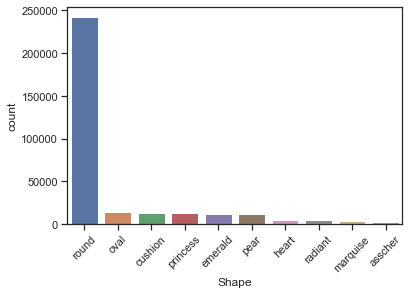

In [627]:
# plot the distribution of diamond shapes
# from the output we see that the distribution is very imbalance. 
# we have far more round diamond shapes than the total of other diamond shapes
sns.set(style='ticks')

shape_plot = sns.countplot(x = 'Shape',data = diamonds_total,order = diamonds_total['Shape'].value_counts().index)

for item in shape_plot.get_xticklabels():
    item.set_rotation(45)

In [628]:
# transform the feature "Shape" into binary values: "round" and "fancy" to reduce the imbalance distribution of diamond shapes
fancy_shape = {
    'fancy':['oval','cushion','princess','emerald','pear','heart','radiant','marquise','asscher']}

for k,v in fancy_shape.items():
    diamonds_total.loc[diamonds_total['Shape'].isin(v), 'Shape'] = k

In [629]:
# validate all the other diamond shapes have been converted to "fancy"
diamonds_total.Shape.unique()

array(['fancy', 'round'], dtype=object)

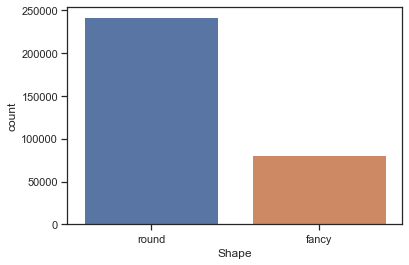

In [630]:
# run the distribution plot of diamond shapes again
sns.set(style='ticks')

shape_plot_after_trans = sns.countplot(x = 'Shape',
              data = diamonds_total,
              order = diamonds_total['Shape'].value_counts().index)

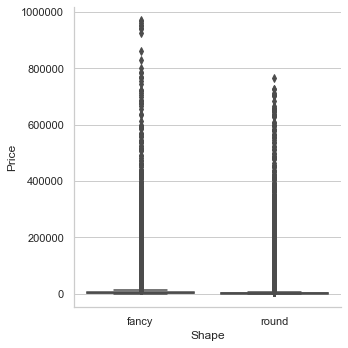

In [631]:
# boxplot of diamond shape vs price
sns.set(style='whitegrid')
shape_box = sns.catplot(x = 'Shape', y = 'Price', data = diamonds_total, kind = 'box')

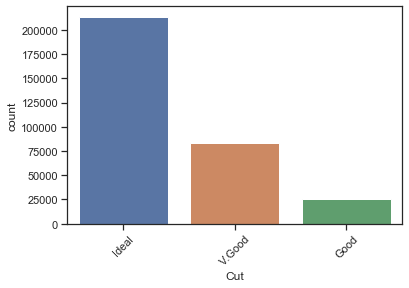

In [632]:
sns.set(style='ticks')

cut_plot= sns.countplot(x = 'Cut',
              data = diamonds_total,
              order = diamonds_total['Cut'].value_counts().index)

for item in cut_plot.get_xticklabels():
    item.set_rotation(45)

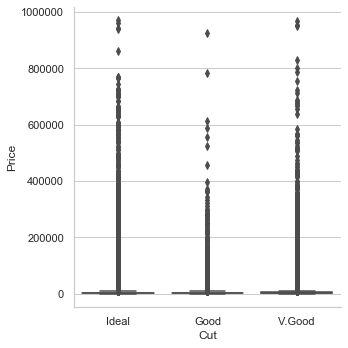

In [633]:
# boxplot of diamond cut vs price
sns.set(style='whitegrid')
shape_box = sns.catplot(x = 'Cut', y = 'Price', data = diamonds_total, kind = 'box')

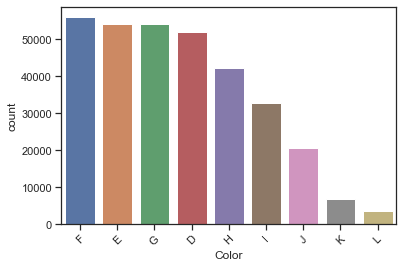

In [634]:
sns.set(style='ticks')

color_plot= sns.countplot(x = 'Color',
              data = diamonds_total,
              order = diamonds_total['Color'].value_counts().index)

for item in color_plot.get_xticklabels():
    item.set_rotation(45)

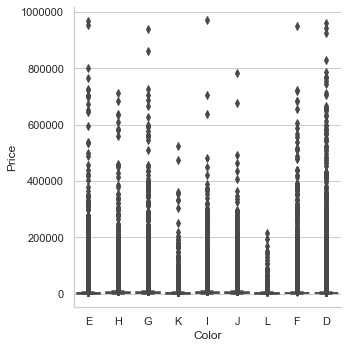

In [635]:
# boxplot of diamond color vs price
sns.set(style='whitegrid')
shape_box = sns.catplot(x = 'Color', y = 'Price', data = diamonds_total, kind = 'box')

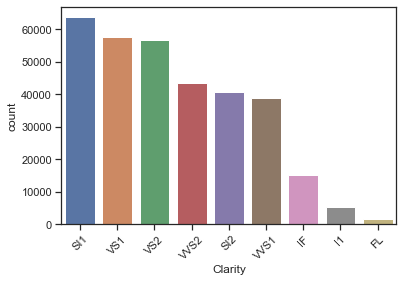

In [636]:
sns.set(style='ticks')

clarity_plot= sns.countplot(x = 'Clarity',
              data = diamonds_total,
              order = diamonds_total['Clarity'].value_counts().index)

for item in clarity_plot.get_xticklabels():
    item.set_rotation(45)

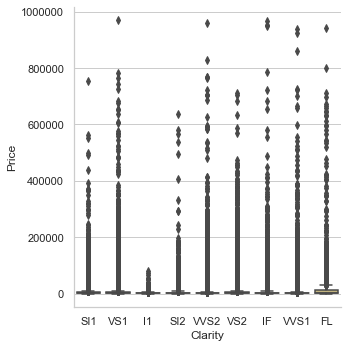

In [637]:
# boxplot of diamond clarity vs price
sns.set(style='whitegrid')
shape_box = sns.catplot(x = 'Clarity', y = 'Price', data = diamonds_total, kind = 'box')

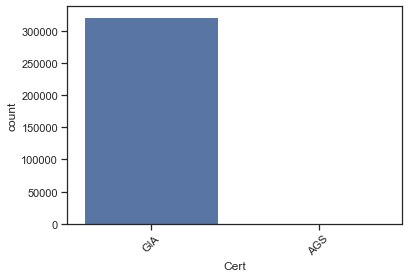

In [638]:
sns.set(style='ticks')

cert_plot= sns.countplot(x = 'Cert',
              data = diamonds_total,
              order = diamonds_total['Cert'].value_counts().index)

for item in cert_plot.get_xticklabels():
    item.set_rotation(45)

In [639]:
# I don't think the "Cert" column will effect too much on the price since almost all of the "Cert" values are GIA
# probably will drop this column in later regression analysis
diamonds_total['Cert'].value_counts()

GIA    322532
AGS       168
Name: Cert, dtype: int64

In [640]:
# drop the 'Cert' column 
diamonds_total.drop(['Cert'], axis=1, inplace = True)

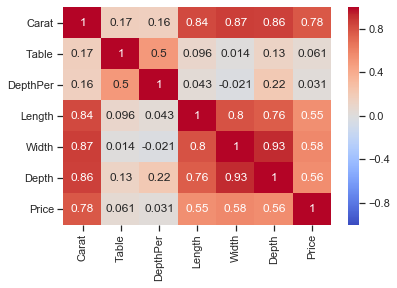

In [641]:
# visualize the correlation with heat map via seaborn
sns.heatmap(diamonds_total.corr(), cmap = "coolwarm", annot = True, vmin = -1, vmax = 1)

In [642]:
# would be nice if I could 'pickle' my pairplot. I will do it if I have extra time!
# visualize pair plot via seaborn to see the correlations betwen variables as scatterplot
# from the plot we could tell that 'Length(mm)', 'Width(mm)', and 'Depth(mm)' are HIGHLY correlated to carat
# sns.pairplot(diamonds_total, kind="scatter", diag_kind = "hist", height=2, aspect=1.5)

In [643]:
diamonds_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322700 entries, 0 to 361972
Data columns (total 11 columns):
Shape       322700 non-null object
Carat       322700 non-null float64
Cut         322700 non-null object
Color       322700 non-null object
Clarity     322700 non-null object
Table       322700 non-null float64
DepthPer    322700 non-null float64
Length      322700 non-null float64
Width       322700 non-null float64
Depth       322700 non-null float64
Price       322700 non-null int64
dtypes: float64(6), int64(1), object(4)
memory usage: 39.5+ MB


In [644]:
diamonds_total = pd.get_dummies(diamonds_total)
diamonds_total.head()

,Carat,Table,DepthPer,Length,Width,Depth,Price,Shape_fancy,Shape_round,Cut_Good,...,Color_L,Clarity_FL,Clarity_I1,Clarity_IF,Clarity_SI1,Clarity_SI2,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2
0,0.22,68.0,64.5,4.25,3.19,2.06,176,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.24,61.0,65.6,4.04,3.34,2.19,179,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.30,69.8,82.0,3.94,3.68,2.57,181,1,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0.34,58.0,68.5,4.14,3.79,2.60,223,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.46,87.0,72.2,4.62,4.19,3.03,280,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### Feature Selection and Feature Engineering

In [645]:
# split the 'Price' column as it's the outcome
X, y = diamonds_total.drop('Price', axis = 1), diamonds_total['Price']

In [646]:
# hold out 20% of the data as test data for final model run
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [647]:
# train my basic OLS model with dataset (without any transformation)
model_basic = sm.OLS(y, X)
modelfit_basic = model_basic.fit()
modelfit_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                 2.698e+04
Date:                Fri, 19 Jul 2019   Prob (F-statistic):               0.00
Time:                        06:02:00   Log-Likelihood:            -2.7620e+06
No. Observations:              258160   AIC:                         5.524e+06
Df Residuals:                  258134   BIC:                         5.524e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Carat         3.834e+04     68.506    559.680      0.000    3.82e+04    3.85e+04
Table         -216.9667      6.744    -32.172      0.000    -230.185    -203.749
DepthPer      -630.2760      8.975    -70.223      0.000    -647.868    -612.684
Length       -2512.1132     35.575    -70.614      0.000   -2581.840   -2442.387
Width        -7765.4615     67.392   -115.228      0.000   -7897.549   -7633.374
Depth        -1776.7475     83.962    -21.161      0.000   -1941.311   -1612.184
Shape_fancy   3.942e+04    371.381    106.134      0.000    3.87e+04    4.01e+04
Shape_round   4.468e+04    322.744    138.440      0.000     4.4e+04    4.53e+04
Cut_Good      2.875e+04    244.075    117.806      0.000    2.83e+04    2.92e+04
Cut_Ideal     2.721e+04    226.963    119.886      0.000    2.68e+04    2.77e+04
Cut_V.Good    2.813e+04    230.877    121.855      0.000    2.77e+04    2.86e+04
Color_D       1.236e+04     92.192    134.088      0.000    1.22e+04    1.25e+04
Color_E       1.176e+04     92.561    127.103      0.000    1.16e+04    1.19e+04
Color_F       1.161e+04     92.929    124.898      0.000    1.14e+04    1.18e+04
Color_G        1.11e+04     94.573    117.337      0.000    1.09e+04    1.13e+04
Color_H       1.022e+04     97.858    104.387      0.000       1e+04    1.04e+04
Color_I       8915.2050    102.027     87.381      0.000    8715.235    9115.175
Color_J       6992.5003    112.105     62.374      0.000    6772.777    7212.224
Color_K       5434.6310    154.323     35.216      0.000    5132.162    5737.100
Color_L       5709.1270    198.555     28.753      0.000    5319.965    6098.289
Clarity_FL    2.212e+04    280.437     78.888      0.000    2.16e+04    2.27e+04
Clarity_I1    6426.8873    173.736     36.992      0.000    6086.370    6767.404
Clarity_IF    9856.1439    120.513     81.785      0.000    9619.941    1.01e+04
Clarity_SI1   6734.2524     96.423     69.841      0.000    6545.267    6923.238
Clarity_SI2   6168.8348    101.239     60.933      0.000    5970.409    6367.261
Clarity_VS1   7970.4060     97.182     82.015      0.000    7779.932    8160.880
Clarity_VS2   7327.3982     97.413     75.220      0.000    7136.471    7518.325
Clarity_VVS1  8971.9428    100.760     89.042      0.000    8774.455    9169.430
Clarity_VVS2  8517.8464     99.686     85.446      0.000    8322.464    8713.229
==============================================================================
Omnibus:                   576386.083   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       8441591656.465
Skew:                          20.622   Prob(JB):                         0.00
Kurtosis:                     887.916   Cond. No.                     1.38e+16
==============================================================================

Warnings:
[1] St

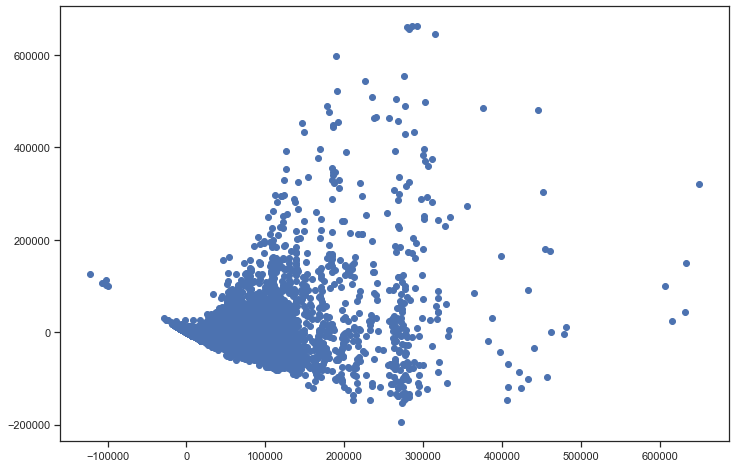

In [648]:
# plot the residual errors for my basic OLS model
# doesn't seem good
plt.figure(figsize=(12,8))
plt.scatter(modelfit_basic.predict(), modelfit_basic.resid)

In [649]:
# the prices of diamonds are very right skewed
# log transform the 'Price' column
y_log = np.log(y)

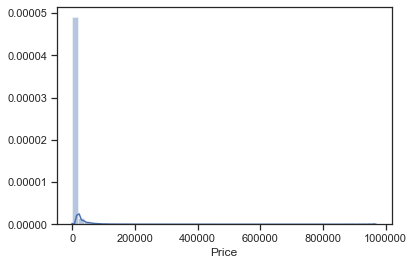

In [650]:
# distribution of y_train before log transformation
sns.distplot(y)

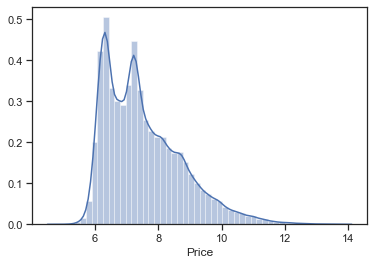

In [651]:
# distribution of y_train after log transformation, it seems to be normal distribution now
# If I have more time, I should've combine the two histgrams in the same section for better comparison
sns.distplot(y_log)

In [652]:
# re-train the OLS model with logged y
# from the stats summary output we can see that the Skew and Kurtosis score were significantly reduced!!
# Skew from 20.622 to 0.065; Kurtosis from 887.916 to 28.273
# but it seems like Kurtosis and Cond. No. score are still very high, may due to high multicollinearity
# could be seen from previous pairplots (the lengh, width, and depth in mm are highly correlated to each other)
# so I need to run VIF to see if I need to drop any features or combine them together for feature engineering
# X = sm.add_constant(X)
model_log = sm.OLS(y_log, X)
modelfit_log = model_log.fit()
modelfit_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 2.501e+05
Date:                Fri, 19 Jul 2019   Prob (F-statistic):               0.00
Time:                        06:02:07   Log-Likelihood:                -850.80
No. Observations:              258160   AIC:                             1754.
Df Residuals:                  258134   BIC:                             2026.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Carat           -0.3623      0.002   -233.527      0.000      -0.365      -0.359
Table            0.0156      0.000    101.932      0.000       0.015       0.016
DepthPer         0.0607      0.000    298.806      0.000       0.060       0.061
Length           0.3145      0.001    390.368      0.000       0.313       0.316
Width            0.7998      0.002    524.091      0.000       0.797       0.803
Depth            0.0735      0.002     38.665      0.000       0.070       0.077
Shape_fancy     -1.6078      0.008   -191.193      0.000      -1.624      -1.591
Shape_round     -1.6353      0.007   -223.761      0.000      -1.650      -1.621
Cut_Good        -1.1460      0.006   -207.361      0.000      -1.157      -1.135
Cut_Ideal       -1.0462      0.005   -203.566      0.000      -1.056      -1.036
Cut_V.Good      -1.0509      0.005   -201.013      0.000      -1.061      -1.041
Color_D         -0.0680      0.002    -32.583      0.000      -0.072      -0.064
Color_E         -0.1153      0.002    -55.018      0.000      -0.119      -0.111
Color_F         -0.1367      0.002    -64.984      0.000      -0.141      -0.133
Color_G         -0.1853      0.002    -86.527      0.000      -0.189      -0.181
Color_H         -0.2542      0.002   -114.707      0.000      -0.259      -0.250
Color_I         -0.3740      0.002   -161.878      0.000      -0.379      -0.369
Color_J         -0.5146      0.003   -202.715      0.000      -0.520      -0.510
Color_K         -0.7391      0.003   -211.513      0.000      -0.746      -0.732
Color_L         -0.8559      0.004   -190.360      0.000      -0.865      -0.847
Clarity_FL       0.1262      0.006     19.875      0.000       0.114       0.139
Clarity_I1      -0.9245      0.004   -235.006      0.000      -0.932      -0.917
Clarity_IF      -0.1258      0.003    -46.087      0.000      -0.131      -0.120
Clarity_SI1     -0.4950      0.002   -226.710      0.000      -0.499      -0.491
Clarity_SI2     -0.6463      0.002   -281.946      0.000      -0.651      -0.642
Clarity_VS1     -0.3198      0.002   -145.327      0.000      -0.324      -0.315
Clarity_VS2     -0.3769      0.002   -170.880      0.000      -0.381      -0.373
Clarity_VVS1    -0.2047      0.002    -89.728      0.000      -0.209      -0.200
Clarity_VVS2    -0.2762      0.002   -122.377      0.000      -0.281      -0.272
==============================================================================
Omnibus:                    68796.654   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6870482.246
Skew:                           0.065   Prob(JB):                         0.00
Kurtosis:                      28.273   Cond. No.                     1.38e+16
==============================================================================

Warnings:
[1] St

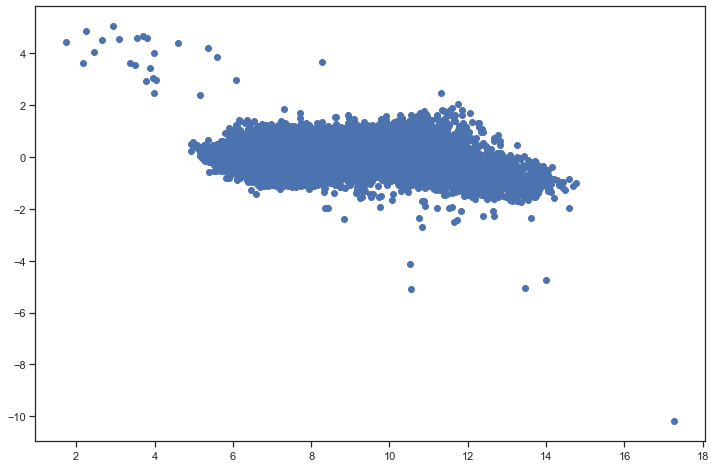

In [653]:
# plot residual errors with my log model
plt.figure(figsize=(12,8))
plt.scatter(modelfit_log.predict(), modelfit_log.resid)

In [654]:
# validate if adjust-rsquare from sklearn linear regression model is the same as it from stats OLS model
# apprears that the results equals. So my code for training model should be correct
lr = LinearRegression()
lr.fit(X, y_log)
r_squared = lr.score(X,y_log)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_log-1)/(len(y_log)-X.shape[1]-1))
print(r_squared,adjusted_r_squared)

0.9603560370772732 0.9603514296357217


In [655]:
# from previous stats model summary output it shows that there are very strong multicollinearity
# here I'm applying VIF to see which features I could drop or combine together
# create a new dataframe with only numeric features from diamonds_total for later calculating VIF
X_numeric = diamonds_total.loc[:,['Carat','Table','DepthPer','Length','Width','Depth']]

In [656]:
# calculate VIF to see which feature (with high VIF score) can be dropped
# (from wikipedia) In statistics, the variance inflation factor (VIF) is the ratio of variance in a model with multiple terms, 
# divided by the variance of a model with one term alone.
# It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. 
# It provides an index that measures how much the variance (the square of the estimate's standard deviation) of 
# an estimated regression coefficient is increased because of collinearity.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
vif["features"] = X_numeric.columns
vif

,VIF Factor,features
0,9.674879,Carat
1,262.722278,Table
2,305.550569,DepthPer
3,51.460793,Length
4,164.627158,Width
5,174.345288,Depth


In [657]:
# it shows that Table, DepthPer, Width, and Depth all have very high VIF scores
# meaning that they are highly correlated to each other, which makes sense
# DepthPer - the height of a diamond, measured from the culet to the table, divided by its average girdle diameter
# Table - The width of the diamond's table expressed as a percentage of its average diameter

In [658]:
# The depth of a diamond is its height (in millimeters) measured from the culet to the table.
# depth percentage shows how deep the diamond is in relation to its width
# When light rays enter a diamond, the depth of a diamond affects how the light rays will travel and be reflected within it.
# stones that are cut too deeply are usually cut to retain weight from the rough)

# The table refers to the flat facet of the diamond which can be seen when the stone is face up
# table percentage is calculated based on the size of the table divided by the average girdle diameter of the diamond.
# If a diamond is round cut, gemologists can compute this value by dividing the table diameter, measured in millimeters by the average girdle diameter.
# For fancy shaped diamonds, table percentage is computed by dividing the table width (measured at the widest part of the facet) 
# by the width of the widest part of the stone measured in millimeters.
# # a bigger table doesn’t mean better looks and vice versa. 
# However, the size of the table can affect the fire dispersion properties of a diamond

In [659]:
# depends on the research of domain knowledge, I want to try combining table and depthPer together
# and then re-train model again to see if it would decrease multicollinearity
X['Table_DepthPer'] = X['Table'] * X['DepthPer'] # create a new feature combining X['Table'] * X['DepthPer'] 
X_new_feature = X.drop(columns = ['Table','DepthPer'])

In [666]:
# tr-train model with new feature
# we can see that the r squared is still good, but Kurtosis and skewness changed a lot
model_new_feature = sm.OLS(y_log, X_new_feature)
modelfit_new_feature = model_new_feature.fit()
modelfit_new_feature.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 2.315e+05
Date:                Fri, 19 Jul 2019   Prob (F-statistic):               0.00
Time:                        06:04:47   Log-Likelihood:                -15445.
No. Observations:              258160   AIC:                         3.094e+04
Df Residuals:                  258135   BIC:                         3.120e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Carat             -0.3421      0.002   -209.017      0.000      -0.345      -0.339
Length             0.3063      0.001    358.787      0.000       0.305       0.308
Width              0.7165      0.002    467.173      0.000       0.713       0.720
Depth              0.1981      0.002    106.458      0.000       0.194       0.202
Shape_fancy       -0.1965      0.005    -38.288      0.000      -0.207      -0.186
Shape_round       -0.2245      0.004    -55.951      0.000      -0.232      -0.217
Cut_Good          -0.1819      0.003    -53.502      0.000      -0.189      -0.175
Cut_Ideal         -0.1273      0.003    -42.400      0.000      -0.133      -0.121
Cut_V.Good        -0.1119      0.003    -36.480      0.000      -0.118      -0.106
Color_D            0.2418      0.002    149.404      0.000       0.239       0.245
Color_E            0.1927      0.002    119.413      0.000       0.190       0.196
Color_F            0.1741      0.002    107.761      0.000       0.171       0.177
Color_G            0.1289      0.002     78.000      0.000       0.126       0.132
Color_H            0.0603      0.002     34.269      0.000       0.057       0.064
Color_I           -0.0583      0.002    -30.953      0.000      -0.062      -0.055
Color_J           -0.1985      0.002    -90.788      0.000      -0.203      -0.194
Color_K           -0.4215      0.003   -125.749      0.000      -0.428      -0.415
Color_L           -0.5405      0.004   -120.253      0.000      -0.549      -0.532
Clarity_FL         0.4308      0.007     65.768      0.000       0.418       0.444
Clarity_I1        -0.6148      0.004   -159.276      0.000      -0.622      -0.607
Clarity_IF         0.1785      0.002     72.432      0.000       0.174       0.183
Clarity_SI1       -0.1768      0.002   -103.630      0.000      -0.180      -0.173
Clarity_SI2       -0.3292      0.002   -176.006      0.000      -0.333      -0.326
Clarity_VS1       -0.0015      0.002     -0.866      0.387      -0.005       0.002
Clarity_VS2       -0.0583      0.002    -33.628      0.000      -0.062      -0.055
Clarity_VVS1       0.1101      0.002     59.380      0.000       0.107       0.114
Clarity_VVS2       0.0401      0.002     22.105      0.000       0.037       0.044
Table_DepthPer     0.0005   1.83e-06    269.103      0.000       0.000       0.000
==============================================================================
Omnibus:                   167978.898   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         91385654.533
Skew:                          -1.843   Prob(JB):                         0.00
Kurtosis:                      95.098   Cond. No.                     1.38e+16
==============================================================================

Warnings:
[1] Standard Errors assum

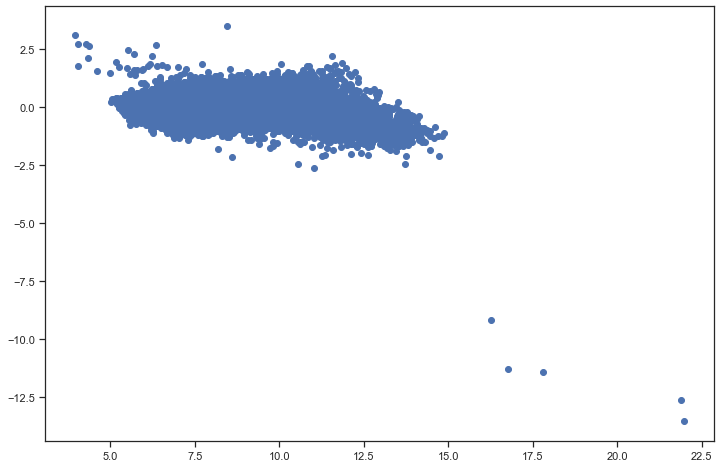

In [667]:
plt.figure(figsize=(12,8))
plt.scatter(modelfit_new_feature.predict(), modelfit_new_feature.resid)

In [668]:
# looks like combining/timing table and depthPer didn't reduce multicollinearity
# let me try to drop table, depthPer, width and depth and re-train the OLS model
X_without = X.drop(columns = ['Width', 'Depth','Table','DepthPer'])

In [671]:
# re-train OLS model again without 'Table','DepthPer','Width', 'Depth'... Hopefully the last time
# we can see that R-square decreased... skewness changed as well...
model_without = sm.OLS(y_log, X_without)
modelfit_without = model_without.fit()
modelfit_without.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 6.815e+04
Date:                Fri, 19 Jul 2019   Prob (F-statistic):               0.00
Time:                        06:09:00   Log-Likelihood:            -1.6991e+05
No. Observations:              258160   AIC:                         3.399e+05
Df Residuals:                  258137   BIC:                         3.401e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Carat              0.3883      0.002    159.851      0.000       0.384       0.393
Length             0.6157      0.001    450.625      0.000       0.613       0.618
Shape_fancy       -0.0336      0.009     -3.677      0.000      -0.051      -0.016
Shape_round        0.7272      0.007    109.585      0.000       0.714       0.740
Cut_Good           0.1726      0.006     28.794      0.000       0.161       0.184
Cut_Ideal          0.2623      0.005     50.415      0.000       0.252       0.272
Cut_V.Good         0.2587      0.005     48.321      0.000       0.248       0.269
Color_D            0.3087      0.003    106.197      0.000       0.303       0.314
Color_E            0.2683      0.003     92.667      0.000       0.263       0.274
Color_F            0.2785      0.003     96.198      0.000       0.273       0.284
Color_G            0.2616      0.003     88.460      0.000       0.256       0.267
Color_H            0.2073      0.003     65.788      0.000       0.201       0.213
Color_I            0.0911      0.003     26.958      0.000       0.085       0.098
Color_J           -0.0612      0.004    -15.534      0.000      -0.069      -0.054
Color_K           -0.2862      0.006    -47.134      0.000      -0.298      -0.274
Color_L           -0.3745      0.008    -45.930      0.000      -0.391      -0.359
Clarity_FL         0.5054      0.012     42.458      0.000       0.482       0.529
Clarity_I1        -0.4323      0.007    -61.842      0.000      -0.446      -0.419
Clarity_IF         0.2399      0.004     53.830      0.000       0.231       0.249
Clarity_SI1       -0.0097      0.003     -3.173      0.002      -0.016      -0.004
Clarity_SI2       -0.1649      0.003    -49.173      0.000      -0.171      -0.158
Clarity_VS1        0.1272      0.003     41.159      0.000       0.121       0.133
Clarity_VS2        0.0845      0.003     27.170      0.000       0.078       0.091
Clarity_VVS1       0.2013      0.003     60.259      0.000       0.195       0.208
Clarity_VVS2       0.1423      0.003     43.652      0.000       0.136       0.149
Table_DepthPer     0.0007   3.08e-06    227.337      0.000       0.001       0.001
==============================================================================
Omnibus:                    88798.707   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1821563.993
Skew:                          -1.155   Prob(JB):                         0.00
Kurtosis:                      15.807   Cond. No.                     1.38e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.95e-20. This might indicate that there are
strong multicollinearit

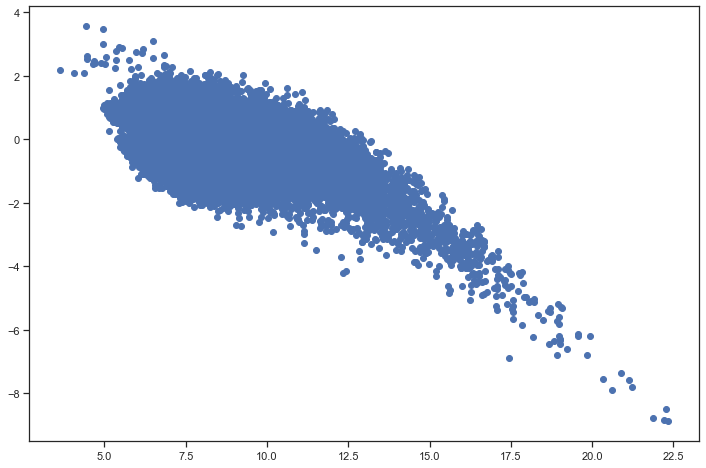

In [672]:
plt.figure(figsize=(12,8))
plt.scatter(modelfit_without.predict(), modelfit_without.resid)

In [510]:
# so it seems like the best features were given by fitting all ORIGINAL predicting features with y_log
# it gives very high adjusted r-squared, the lowest skewness, but strong multicollinearity
# I don't have more time working more on the multicollinearity but I difinitely will come back and analyze it
# adding new combination of features or dropping features didn't improve the OLS performance very well
# so I will train and test models with y_log and all the ORIGINAL predictors

### Model Training and Validation

In [674]:
# drop the new feature 'Table_DepthPer' that I created previously
# so now the X dataframe only has the original predictors
X = X.drop(columns = ['Table_DepthPer'])

In [675]:
# since I have too many observations to split training and validation data, I have to keep the folds less than 3
print('The rows and columns number I have for training model is: ', X.shape)

The rows and columns number I have for training model is:  (258160, 29)


In [676]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258160 entries, 180053 to 116409
Data columns (total 29 columns):
Carat           258160 non-null float64
Table           258160 non-null float64
DepthPer        258160 non-null float64
Length          258160 non-null float64
Width           258160 non-null float64
Depth           258160 non-null float64
Shape_fancy     258160 non-null uint8
Shape_round     258160 non-null uint8
Cut_Good        258160 non-null uint8
Cut_Ideal       258160 non-null uint8
Cut_V.Good      258160 non-null uint8
Color_D         258160 non-null uint8
Color_E         258160 non-null uint8
Color_F         258160 non-null uint8
Color_G         258160 non-null uint8
Color_H         258160 non-null uint8
Color_I         258160 non-null uint8
Color_J         258160 non-null uint8
Color_K         258160 non-null uint8
Color_L         258160 non-null uint8
Clarity_FL      258160 non-null uint8
Clarity_I1      258160 non-null uint8
Clarity_IF      258160 non-null uint

In [677]:
X, y = np.array(X), np.array(y_log)

In [678]:
# these codes are for troubleshooting as I have this error "Input contains NaN, infinity or a value too large for dtype('float64')"
# there are no NaN or infinite values in X or y
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))
print(np.any(np.isnan(y)))
print(np.all(np.isfinite(y)))

False
True
False
True


In [680]:
# cross validation with X and y_log, failed
# but I was able to cross validation with X and y...
# it keeps popping this error "Input contains NaN, infinity or a value too large for dtype('float64')."
# I've looked NaN or infinite values in those two np.arrays but I didn't find any
# I've troubleshoot with fellows for hours but couldn't solve the problem... so my cross validation stopped here
kf = KFold(n_splits=10, shuffle=True, random_state = 2)
cv_lm_r2s, cv_lm_reg_r2s,cv_poly_r2s = [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]  # y_log failed
    X_val, y_val = X[val_ind], y[val_ind] # y_log failed
    
    #simple linear regression
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #polynomial regression
    lm_poly = LinearRegression()
    polynomial_features = PolynomialFeatures(degree=2)
    X_poly = polynomial_features.fit_transform(X_train)
    X_val_poly = polynomial_features.transform(X_val)
    lm_poly.fit(X_poly, y_train)
    cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
    
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg = Ridge(alpha=1)
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
print('Poly scores: ', cv_poly_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Poly mean cv r^2: {np.mean(cv_poly_r2s):.3f} +- {np.std(cv_poly_r2s):.3f}')

Simple regression scores:  [0.9609956563855999, 0.9608938102991403, 0.9566092851755797, 0.9594141148901045, 0.9616489342462031, 0.9599780466690642, 0.961444713886573, 0.9591350117566203, 0.9605540623743276, 0.9609596945247809]
Ridge scores:  [0.9609957108725681, 0.9608938426542047, 0.956606931651019, 0.9594145372484627, 0.9616491228575137, 0.9599784315112724, 0.9614449125879614, 0.9591341666647779, 0.9605535392708608, 0.960959967582159] 

Poly scores:  [0.9841751797536074, 0.9840427035566023, 0.9663255833039788, 0.9829777689714702, 0.9835716790287202, 0.9835694365561557, 0.9843176151124574, 0.9833224531404829, 0.9735176376454365, -254.89595285218695] 

Simple mean cv r^2: 0.960 +- 0.001
Ridge mean cv r^2: 0.960 +- 0.001
Poly mean cv r^2: -24.607 +- 76.763


In [681]:
# there is really strange outliers from the poly r**2, so I remove it
cv_poly_r2s = cv_poly_r2s[:-1]
print(f'Poly mean cv r^2: {np.mean(cv_poly_r2s):.3f} +- {np.std(cv_poly_r2s):.3f}')

Poly mean cv r^2: 0.981 +- 0.006


In [682]:
# coefficient of my ridge regression model
list(zip(diamonds_total.columns, lm_reg.coef_))

[('Carat', -0.28228491239035935),
 ('Table', 0.06413204294365665),
 ('DepthPer', 0.21987355869113653),
 ('Length', 0.4814504654023417),
 ('Width', 0.9728026015616641),
 ('Depth', 0.054717755527994134),
 ('Price', 0.005964643424203499),
 ('Shape_fancy', -0.005964643423005309),
 ('Shape_round', -0.022639514161563616),
 ('Cut_Good', 0.00823579955429188),
 ('Cut_Ideal', 0.005214550203678386),
 ('Cut_V.Good', 0.056225023796657725),
 ('Color_D', 0.03956481360469803),
 ('Color_E', 0.03212259065545117),
 ('Color_F', 0.01350340811106751),
 ('Color_G', -0.0109912546082638),
 ('Color_H', -0.04637283028098869),
 ('Color_I', -0.071782073220157),
 ('Color_J', -0.07425004834854336),
 ('Color_K', -0.06584818494543829),
 ('Color_L', 0.03598942813539178),
 ('Clarity_FL', -0.06861794139539419),
 ('Clarity_I1', 0.054280879499801975),
 ('Clarity_IF', -0.044700513925241186),
 ('Clarity_SI1', -0.08742196127279332),
 ('Clarity_SI2', 0.02419426310953142),
 ('Clarity_VS1', 0.002291323937364203),
 ('Clarity_VS2'

In [683]:
# coefficient of my linear regression model
list(zip(diamonds_total.columns, lm_poly.coef_))

[('Carat', 966.928237983944),
 ('Table', 131529.3767243235),
 ('DepthPer', -6360147.146220196),
 ('Length', -37185328.33943415),
 ('Width', -12380057.003874293),
 ('Depth', -6810305.55787354),
 ('Price', -457786.58031246514),
 ('Shape_fancy', -54462.988188151954),
 ('Shape_round', -420111.96161635336),
 ('Cut_Good', 434176.00587512256),
 ('Cut_Ideal', 288054.3576015336),
 ('Cut_V.Good', 681469.7877550907),
 ('Color_D', -224983.86449571053),
 ('Color_E', 329283.9990060254),
 ('Color_F', -617727.6123929312),
 ('Color_G', 458948.26755771204),
 ('Color_H', 874989.5287368817),
 ('Color_I', -779976.5954094244),
 ('Color_J', 331310.3935025252),
 ('Color_K', -56118.70182707135),
 ('Color_L', 883535.012106517),
 ('Clarity_FL', 261883.58553669957),
 ('Clarity_I1', -62843.67772736406),
 ('Clarity_IF', -723948.9592809819),
 ('Clarity_SI1', -70186.46645021916),
 ('Clarity_SI2', 1234114.7819220065),
 ('Clarity_VS1', -69124.60388384254),
 ('Clarity_VS2', 334767.72723529907),
 ('Clarity_VVS1', -73417.

In [684]:
# coefficient of my polynomial regression model
list(zip(diamonds_total.columns, lm.coef_))

[('Carat', -0.3624647822903372),
 ('Table', 0.015587647547465498),
 ('DepthPer', 0.0612312324683504),
 ('Length', 0.31457821655001494),
 ('Width', 0.8039047689402241),
 ('Depth', 0.06679892289190925),
 ('Price', 0.013780998163818529),
 ('Shape_fancy', -0.01378099816385221),
 ('Shape_round', -0.06510155292152722),
 ('Cut_Good', 0.03529050338234279),
 ('Cut_Ideal', 0.02981104953921549),
 ('Cut_V.Good', 0.2921592442691619),
 ('Color_D', 0.24503492317855655),
 ('Color_E', 0.22411758877301236),
 ('Color_F', 0.17545864900135325),
 ('Color_G', 0.10674032174092425),
 ('Color_H', -0.01386776445381675),
 ('Color_I', -0.15494644613223518),
 ('Color_J', -0.3783011096190491),
 ('Color_K', -0.49639540675794663),
 ('Color_L', 0.48692107087933584),
 ('Clarity_FL', -0.565867161218404),
 ('Clarity_I1', 0.23460023650472236),
 ('Clarity_IF', -0.13489676835976042),
 ('Clarity_SI1', -0.2857443459235039),
 ('Clarity_SI2', 0.0406003505234445),
 ('Clarity_VS1', -0.016589783414402683),
 ('Clarity_VS2', 0.156586

In [685]:
# test on my ridge regression model with test dataset
# i knew that there is something wrong...
X_test_scaled = scaler.transform(X_test)
test_set_pred = lm_reg.predict(X_test_scaled)
r2_score(y_test, test_set_pred)

-0.0702172004365178

In [686]:
# test on my linear regression model with test dataset
X_test_scaled = scaler.transform(X_test)
test_set_pred = lm.predict(X_test_scaled)
r2_score(y_test, test_set_pred)

-0.07051904236088857

In [687]:
# test on my polynomial regression model with test dataset
X_test_scaled = polynomial_features.transform(X_test)
test_set_pred = lm_poly.predict(X_test_scaled)
r2_score(y_test, test_set_pred)

-0.07021881148670994

#### Below are some code that I used to manipulate data, detect/remove outliers previously, could ignore them. Removing outliers didn't improve too much on my previous OLS model so I decided to remove the code section

In [ ]:
# I feel like the residual error plots doesn't look good, seems like there is a trend
# I'm not sure if that's due to the model itself or the outliers on the residual plot 
# so I decided to filter out the outliers of X_train, y_log_train to see if the residual plots still have a trend
# I'm not sure if there is an easier way to manipulate the np arrays as previously I've set X_train and y_train(as well as y_log_train)
# as np arrays, so I need to concate the two arrays (X_train and y_log_train) together and then filter out the outliers
# please let me know if there is more easier/elegant way to do so, thanks!
# spent very long time trouble shooting this code but I really enjoyed manipulating data with pandas and numpy!
# then I realized I could also do this way: concate the X_train and y_log_train together as a dataframe,
# then apply z = np.abs(stats.zscore(boston_df)) -> then filter out outliers -> split the dataframe -> convert to np.array again... 
# or, I could do another way... concat the two arrays together and apply print(np.where(z > 3)) directly...

concat = np.hstack((X_train,y_log_train[np.newaxis].T)) # firstly transpose y_log_train to vertical and then concat X_train and Y_log_train horizontally
outlier = concat[concat[:,-1] > np.quantile(concat[:,-1], 0.99)] # filter the outliers. here I used all logged prices over 99% quantile
non_outlier = concat[concat[:,-1] < np.quantile(concat[:,-1], 0.99)] # filter out outliers. these data will be trained on OLS again to see if any improvements on residual plot

In [ ]:
# assure I didn't loose any data when manipulate data
len(X_train) == len(y_log_train) == len(outlier) + len(non_outlier)

In [ ]:
# use array indexing to split the np array "concat" into two np X_0outlier_train and y_log_0outlier_train
# I was soooo excited that I learned numpy indexing
# but then I realized... I don't have to use 'only' np.array object to train OLS model... Previously we set up np.array was for k-folds cross validation purpose...
# I could've just concat X_train and y_log_train as data frame -> filter out outliers -> subset the dataframe for X_0outlier_train and y_log_0outlier_train -> train OLS model
X_0outlier_train = non_outlier[:,:29]
y_log_0outlier_train = non_outlier[:,29:]

In [ ]:
# finally train model on non-outlier data!!! 
model_no_outlier = sm.OLS(y_log_0outlier_train, X_0outlier_train)
modelfit_no_outlier = model_no_outlier.fit()
modelfit_no_outlier.summary()